In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import scipy.io
import os

In [2]:
v_th=0.6
SC_base_dir= '/gerda/mcintosh_lab/jgriffiths/hcp_wuminn_l2k8_tracks_conmats/data/results/hcp_wuminn/tractography/dipy/l2k8/'
TS_base_dir='/gerda/mcintosh_lab/jgriffiths/hcp_wuminn_l2k8_rsfmri_ts/data/results/'
out_dir =  '/brunhild/mcintosh_lab/jwang/ModelFitting/HCP/Deco_orig/' #'/brunhild/mcintosh_lab/jwang/ModelFitting/Linear_gains/'
import pandas as pd
#groups =[grp for grp in os.listdir(base_dir)]
TS_df=pd.read_pickle('/scratch/mcintosh_lab/jgriffiths/hcp_wuminn_l2k8_rsfmri_ts_LATEST/data/results/100307_rfMRI_REST1_LR_hpc200_clean__l2k8_sc33_ts.pkl')

In [3]:
TS=TS_df.values

In [4]:

def smooth_normalize(x):
        x[x< 0.000001] =0.000001
    
        return x
def f_diffusion_tr_noise(X, Wo, Theta):
    
    def smooth_normalize_ct(x, center):
        return center+ (center-0.001)*np.tanh((x-center)/(center - 0.001))
    def smooth_normalize(x):
        x[x< 0.000001] =0.000001
    
        return x

    def sigmoid(a, b, d, x):
        return (0.001+np.abs(a*x-b))/(0.00001+np.abs(1.0-np.exp(-d*(a*x-b))))
    #G = 5000.0/0.4590/0.641  + 4000.*np.tanh(Theta[4:5])
    G=  10.+ smooth_normalize(Theta[1:2])#100.*np.tanh(Theta[1:2])#0.001 + smooth_normalize(Theta[1:2])
    
    gEI= 0.001+ smooth_normalize(Theta[2:3])
    W1=  0.001 +smooth_normalize(Theta[0:1])#.0126 + 0.0125*np.tanh(Theta[0:1])
    #W2= .0126 + 0.0125*np.tanh(Theta[0:1])
    gEE= 0.001+ smooth_normalize(Theta[3:4])
    #gEE= 10.17#+ smooth_normalize(Theta[2:3])
    gIE= 0.001+ smooth_normalize(Theta[4:5])
    #Tr= 1.
    #step_size = 0.05
    num_para = 0
    dt = step_size
    state_size = np.int(Tr/step_size)
    N=1
    #ROI_size=96
    #Jnmda = 0.15
    #W=(Gi*W0)/np.linalg.norm(Gi*W0)
    L_s = -np.diag(np.sum(Wo, axis= 1)) + Wo
    I0 = 0.3772 
    Ie = 0
     #smooth_normalize_ct(_Ji[:,0],1.0)
    aE = 310+ 10*np.tanh(Theta[6:7])#310
    bE = 125+ 10*np.tanh(Theta[7:8])#125
    dE_0 = 0.16+ 0.06*np.tanh(Theta[8:9])#0.16
    WE = 0.5+ 0.5*np.tanh(Theta[5:6])
    
    
    aI = 615+ 10*np.tanh(Theta[10:11])#615
    bI = 177+ 10*np.tanh(Theta[11:12])#177
    dI_0 = 0.087+ 0.04*np.tanh(Theta[12:13])#0.087
    WI = 0.5+ 0.5*np.tanh(Theta[9:10])
    
    tauE = 100.
    tauI = 10.
    
    gamma = 0.641/1000.
    gammaI = 1/1000.
    
    
    #W1= 0.05
    
    #G = .1
    
    E = X[num_para:num_para+N*ROI_size]#smooth_normalize_ct(X[num_para:num_para+N*ROI_size], 0.5)
    I = X[num_para+N*ROI_size:num_para+2*N*ROI_size]#smooth_normalize_ct(X[num_para+N*ROI_size:num_para+2*N*ROI_size], .5)
    q = X[-N*ROI_size:] #smooth_normalize_ct(X[-N*ROI_size:],1.0)
    v = X[-2*N*ROI_size:-N*ROI_size]#smooth_normalize_ct(X[-2*N*ROI_size:-N*ROI_size],1.)
    f = X[-3*N*ROI_size:-2*N*ROI_size]#smooth_normalize_ct(X[-3*N*ROI_size:-2*N*ROI_size], 1.)
    x = X[-4*N*ROI_size:-3*N*ROI_size]#np.tanh(X[-4*N*ROI_size:-3*N*ROI_size])#smooth_normalize(X[-4*N*ROI_size:-3*N*ROI_size], .5)
    #print(E.shape)
    #subID='AD_016_S_4902.mat'
    
    
    rho=0.34;
    tau_0=0.98;
    #tau_s=0.8;
    #tau_f=0.4;
    alpha =0.32;
    #s=0.5;
    #E = np.tanh(E/200.0)
    #I =np.tanh(I/200.0)
    def fout(v, k):
        return (k*v)**(1.0/alpha)/k
    def Ef(f,k):
        return 1.0-(1.0- rho)**(1.0/f/k)
    
    
    k = 1.
    #x=x/(np.max(np.abs(x))+0.002)
    #print E.shape
    sigma = 1.
    
    epsilon = 1.0 #+ 0.2 *np.tanh(Theta[5:6]) # smooth_normalize(X[5:6], 0.5)
    tau_s = 0.65 #+ 0.2 *np.tanh(Theta[6:7])
    tau_f = 0.41 #+ 0.2 *np.tanh(Theta[7:8])
    for i in range(state_size):
        #yE=np.tanh(E)
        #yI=np.tanh(I)
        
        
        IE = 1*WE*I0 + gEE*E + G*np.dot(L_s, E) -gIE*(I) + Ie
        II = WI*I0 + gEI*E - I 
         
        dE =  E - dt*E/tauE \
           +dt*(1-E)*gamma*sigmoid(aE, bE, dE_0, IE) \
                +1.*W1*np.sqrt(dt)*np.random.randn(ROI_size)#np.sqrt(dt)
            
        
        dI =  I - dt*I/tauI \
            +dt*1/tauI*np.tanh(gammaI*sigmoid(aI, bI, dI_0, II))\
            +W1*np.sqrt(dt)*np.random.randn(ROI_size)#np.sqrt(dt)
        
        
        
        E = dE#1.0 + np.tanh(dE - 1.0) #smooth_normalize_ct(dE, 1.0)#np.tanh(dE/200.0)
        I = dI#1.0 + np.tanh(dI - 1.0)#smooth_normalize_ct(dI, 1.0)#np.tanh(dI/200.0)
    """return np.concatenate((g1,g2,g12,g21,sigma,epsilon,tau_s,tau_f,\
                           E, I, x, f, v, q))"""
    return np.concatenate((E, I, x, f, v, q))

def h_diffusion_noise(X, Theta):
    def smooth_normalize_ct(x, center):
        return center+ (center-0.001)*np.tanh((x-center)/(center - 0.001))
    
    E = X[:ROI_size]
    
    return E #100.0/E0*V*(y)#+W2*np.random.randn(ROI_size)

In [12]:
Tr= 0.75
num_epochs =30*1
echo_step = 1
num_data = TS.shape[0]
truncated_backprop_length = 15
overlaping=0
total_series_length = num_data -echo_step #50000

step_size = 0.05
state_size = 2 #np.int(6* Tr/step_size)

num_classes = 1
batch_size = 83
num_batches = total_series_length//truncated_backprop_length

In [13]:
tf.reset_default_graph()
    
    
L_new = tf.placeholder(tf.float32, [batch_size, batch_size])
batchX_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length+2*truncated_backprop_length*np.int(Tr/step_size)])
batchY_placeholder = tf.placeholder(tf.float32, [batch_size, truncated_backprop_length])

init_state = tf.placeholder(tf.float32, [batch_size, state_size])





def smooth_normalize_ct(x, center):
   
    return center+ (center-0.001)*tf.tanh((x-center)/(center - 0.001))

def ht(a, b, d, x):
        return (0.001+tf.abs(a*x-b))/(0.00001+tf.abs(1.0-tf.exp(-d*(a*x-b))))



sigma = tf.constant(1.0, dtype=tf.float32) 
epsilon = tf.constant(1.0, dtype=tf.float32)# + 0.3 *np.tanh(X[5:6]) # smooth_normalize(X[5:6], 0.5)
tau_s = tf.constant(0.65, dtype=tf.float32)# + 0.2 *np.tanh(X[6:7])
tau_f = tf.constant(0.41, dtype=tf.float32)# + 0.3 *np.tanh(X[7:8])

I0=tf.constant(0.3772, dtype=tf.float32)
gamma = tf.constant(0.641/1000, dtype=tf.float32)
gammaI = tf.constant(1.0/1000, dtype=tf.float32)

dt = tf.constant(step_size, dtype=tf.float32)

Ie = tf.constant(0.0, dtype=tf.float32)

aE=tf.Variable(0, dtype=tf.float32)
bE = tf.Variable(0, dtype=tf.float32)
dE =tf.Variable(0, dtype=tf.float32)
WE= tf.Variable(0, dtype=tf.float32)
tauE= tf.constant(100, dtype=tf.float32)

aI=tf.Variable(0, dtype=tf.float32)
bI = tf.Variable(0, dtype=tf.float32)
dI =tf.Variable(0, dtype=tf.float32)
WI= tf.Variable(0, dtype=tf.float32)
tauI= tf.constant(10, dtype=tf.float32)


g0 = 10.

   
W1 = tf.Variable(0.05, dtype=tf.float32)
#W2 = tf.Variable(0.01, dtype=tf.float32)
gEE =tf.Variable(0.15, dtype=tf.float32)
G = tf.Variable(g0, dtype=tf.float32)

gEI = tf.Variable(0.15, dtype=tf.float32)

gIE = tf.Variable(0.3, dtype=tf.float32)   
    
L= -tf.diag(tf.reduce_sum(L_new, axis=1)) + L_new
# Unpack columns

inputs_series = tf.unstack(batchX_placeholder, axis=1)
labels_series = tf.unstack(batchY_placeholder, axis=1)

# Forward pass
current_state = init_state
#current_state = _current_state
states_series = []

logits_series = []
noise2 = inputs_series[-truncated_backprop_length:]

G_p = 10. + tf.nn.relu(G)# 100.*tf.tanh(G)#0.001+ tf.nn.relu(G)
W1_p = 0.001 + tf.nn.relu(W1)
gIE_p =0.001 + tf.nn.relu(gIE) #smooth_normalize_ct(Ji, tf.constant(1.0, dtype=tf.float32), tf.constant(0.0, dtype=tf.float32), tf.constant(1.0, dtype=tf.float32))
    
gEI_p =0.001 +tf.nn.relu(gEI)
gEE_p =0.001 +tf.nn.relu(gEE)
    
    
aE_p = 310.+ 100.*tf.tanh(aE)#310
bE_p = 125.+ 10.*tf.tanh(bE)#125
dE_p = 0.16+ 0.02*tf.tanh(dE)#0.16
WE_p = 0.5+ 0.5*tf.tanh(WE)
    
    
aI_p = 615.+ 100.*tf.tanh(aI)#615
bI_p = 177.+ 20.*tf.tanh(bI)#177
dI_p = 0.087+ 0.02*tf.tanh(dI)#0.087
WI_p = 0.5+ 0.5*tf.tanh(WI)

for j, label_tmp in enumerate(labels_series):
    #current_input = tf.reshape(current_input, [batch_size, 1])
    #input_and_state_concatenated = tf.concat([current_input, current_state],1)  # Increasing number of columns
    
    
  
    E=current_state[:,0:1]
    I=current_state[:,1:2]
   
    
   
    for i in range(np.int(Tr/step_size)):
        
        #yE= tf.tanh(E) #smooth_normalize_ct(E_new, tf.constant(1., dtype=tf.float32), tf.constant(0., dtype=tf.float32), tf.constant(1.0, dtype=tf.float32))
        #yI= tf.tanh(I)
        
        noise = tf.reshape(inputs_series[j*np.int(Tr/step_size)+i],[batch_size, 1] )
        noise1 = tf.reshape(inputs_series[truncated_backprop_length*np.int(Tr/step_size)\
                                          +j*np.int(Tr/step_size)+i],[batch_size, 1] )
       
        IE = WE_p*I0 + gEE_p*E + G_p*tf.matmul(L, E) -gIE_p*(I) + Ie
        II = WI_p*I0 + gEI_p*E - I
        
        #IE = 125/310.0 -0.026 +0.006*tf.tanh(IE/100. - 125/310.0 + 0.026) 
        #(3.0631+0.4869*tf.tanh(h_tf(aE, bE, dE, IE)-3.0631)) 
        E_new =E - dt*E/tauE \
                    + dt*(1-E)*tf.tanh(gamma*ht(aE_p,bE_p,dE_p,IE)) +1.0*W1_p*tf.sqrt(dt)*noise
        I_new =I - dt*I/tauI\
                    + dt*1/tauI*tf.tanh(tauI*gammaI*ht(aI_p,bI_p,dI_p,II))\
                    +W1_p*tf.sqrt(dt)*noise1
        
        
        
        E= tf.tanh(E_new) #smooth_normalize_ct(E_new, tf.constant(1., dtype=tf.float32), tf.constant(0., dtype=tf.float32), tf.constant(1.0, dtype=tf.float32))
        I= tf.tanh(I_new) #smooth_normalize_ct(I_new, tf.constant(1., dtype=tf.float32), tf.constant(0., dtype=tf.float32), tf.constant(1.0, dtype=tf.float32))
        
        #E_fr = sigmoid_tf(aE, bE, dE, IE)
    next_state = tf.concat([E, I],1)  # Broadcasted addition
    #IE = WE*I0 + Wplus_p*Jnmda_p*E + G_p*Jnmda_p*tf.matmul(W, E) -tf.multiply(Ji_p,I) + Ie
    #E_fr = h_tf(aE, bE, dE, IE)
    states_series.append(next_state)
    #inhi_series.append(E_fr)
    current_state = next_state 
#current_state = states_series[0]
print(states_series[0].shape)
print(inputs_series[0].shape)
print(len(inputs_series))
#logits_series = [tf.reshape(tf.matmul(W2, tf.reshape(tf.tanh(state), [batch_size*state_size, 1])) + b2, [batch_size,]) for state in states_series]#Broadcasted addition


logits_series = [state[:, 0]+0.02*noise   for state, noise in zip(states_series, noise2)]
                 
print(logits_series[0].shape)
print(labels_series[0].shape)

predictions_series = logits_series

labels_series_tf = tf.stack(labels_series,axis=1)
logits_series_tf = tf.stack(logits_series,axis=1)
#labels_series_tf = labels_series[0]
#logits_series_tf = states_series[0]
labels_series_tf_n = labels_series_tf - tf.matmul(tf.reshape(tf.reduce_mean(labels_series_tf, 1), [batch_size,1]),\
                            tf.constant(np.ones((1,truncated_backprop_length)), dtype=tf.float32))
logits_series_tf_n = logits_series_tf - tf.matmul(tf.reshape(tf.reduce_mean(logits_series_tf, 1), [batch_size,1]),\
                            tf.constant(np.ones((1,truncated_backprop_length)), dtype=tf.float32))


cov_sim =tf.matmul(logits_series_tf_n, tf.transpose(logits_series_tf_n))
cov_def= tf.matmul(labels_series_tf_n, tf.transpose(labels_series_tf_n))


FC_sim_T = tf.matmul(tf.matmul(tf.diag(tf.reciprocal(tf.sqrt(tf.diag_part(cov_sim)))), cov_sim), \
                     tf.diag(tf.reciprocal(tf.sqrt(tf.diag_part(cov_sim)))))
FC_T = tf.matmul(tf.matmul(tf.diag(tf.reciprocal(tf.sqrt(tf.diag_part(cov_def)))), cov_def), \
                 tf.diag(tf.reciprocal(tf.sqrt(tf.diag_part(cov_def))))) 
#FC_T= tf.constant(FC, dtype=tf.float32)

ones_tri=tf.matrix_band_part(tf.ones_like(FC_T), 0, -1)
zeros = tf.zeros_like(FC_T) # create a tensor all ones
mask = tf.greater(ones_tri, zeros) # boolean tensor, mask[i] = True iff x[i] > 1
FC_tri_v = tf.boolean_mask(FC_T, mask)

FC_v = FC_tri_v #- tf.reduce_mean(FC_tri_v)*tf.ones_like(FC_tri_v)


FC_sim_tri_v = tf.boolean_mask(FC_sim_T, mask)
FC_sim_v = FC_sim_tri_v #- tf.reduce_mean(FC_sim_tri_v)*tf.ones_like(FC_sim_tri_v)

corr_FC =tf.reduce_sum(tf.multiply(FC_v,FC_sim_v))\
                  /tf.sqrt(tf.reduce_sum(tf.multiply(FC_v,FC_v)))\
                /tf.sqrt(tf.reduce_sum(tf.multiply(FC_sim_v,FC_sim_v)))
        
losses_corr = 1- corr_FC
losses = tf.sqrt(tf.reduce_mean(tf.multiply(FC_sim_v-FC_v, FC_sim_v-FC_v)))
#losses = tf.sqrt(tf.reduce_mean(tf.multiply(cov_sim-cov_def, cov_sim-cov_def)))

    
#total_loss = losses_corr #+ 0.00012*G**2
#losses = tf.sqrt(tf.reduce_mean(tf.multiply(FC_sim_v-FC_v, FC_sim_v-FC_v)))
#losses = tf.sqrt(tf.reduce_mean(tf.multiply(cov_sim-cov_def, cov_sim-cov_def)))

    
#total_loss = losses_corr #+ 0.05*W1**2
      

#losses = [tf.losses.mean_squared_error(labels, logits) for logits, labels in zip(logits_series,labels_series)]

total_loss = tf.reduce_mean(losses) #+ 0.0002*G**2#+ 0.01*(g1**2 + 2*g12**2 + g21**2)


opt_func = tf.train.AdamOptimizer(.01)




train_step=opt_func.minimize(total_loss)
#train_step = tf.train.GradientDescentOptimizer(.05).minimize(total_loss)
#train_step = tf.train.MomentumOptimizer(learning_rate=0.08, momentum=0.9).minimize(total_loss)
#train_step = tf.train.AdamOptimizer(0.02).minimize(total_loss)
def plot(batch_idx, y_array,x_array, params_list, loss_list, batchX, batchY):
       
    plt.subplot(2, 2, 1)
    plt.cla()
    plt.plot(loss_list)
    
    plt.subplot(2, 2, 2)
    plt.cla()
    plt.plot(params_list)
    
    
    plt.subplot(2, 2, 3)
    plt.cla()
    plt.plot(x_array.T)
    
    
    plt.subplot(2, 2, 4)
    plt.cla()
    plt.plot(y_array.T)

    
        
    plt.draw()
    plt.pause(0.0001)

(83, 2)
(83,)
465
(83,)
(83,)


In [14]:
def model_run(subID,L_s, TS):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        plt.ion()
        plt.figure()
        plt.show()
        loss_list = []
        params_list = []
        
        
       
        G_old =100.
        gEI_old = .15
        W1_old = 0.5
        W2_old = 0.5
        gEE_old = .15
        gIE_old = 1.
    
   
        loss_array_old = np.zeros((truncated_backprop_length,))
    
    
        for epoch_idx in range(num_epochs):
        
            #TS_dmean =(TS.T -TS.T.mean(axis= 0)).T
            y_in= TS.T[:,echo_step:num_data]/np.max(TS)
            if len(loss_list) == 0 or loss_list[len(loss_list)-1]> 0.00002:
            
                y_array =np.zeros((batch_size,(num_batches-1)*(truncated_backprop_length-overlaping)+truncated_backprop_length))
                x_array =np.zeros((batch_size,num_batches*truncated_backprop_length))
                
                initi_con = .2*np.random.uniform(0,1,[batch_size, state_size])#+np.array([[0, 0, 0,1.1,1.1,1.1]]))
                #initi_con[:,0:2]= 0
                _current_state = initi_con
            
            
                params_old = np.array([W1_old, G_old])
                #print("New data, epoch", epoch_idx)
                loss_array = np.zeros((num_batches,))
                for batch_idx in range(num_batches):
                
                    
                    #for batch_idx in range(209-truncated_backprop_length):
                    start_idx = batch_idx * truncated_backprop_length
                    #start_idx = batch_idx 
                    end_idx = start_idx + truncated_backprop_length

                    batchX = np.random.randn(batch_size, truncated_backprop_length+2*truncated_backprop_length*np.int(Tr/step_size))
                    batchY = y_in[:,start_idx:end_idx]

                    _G,  _W1, _gEI, _gEE, _gIE, _WE, _aE,_bE, _dE, _WI, _aI, _bI, _dI, _total_loss, _train_step, _current_state,\
                               _logits_series = sess.run(
                    [G,  W1, gEI, gEE, gIE, WE, aE, bE, dE, WI, aI, bI, dI, total_loss, train_step, current_state, logits_series],
                    feed_dict={
                        batchX_placeholder:batchX,
                        batchY_placeholder:batchY,
                        init_state:_current_state,
                        L_new:L_s
                        })

                    loss_list.append(_total_loss)
                    params_new = np.array([_G,  _W1, _gEI, _gEE, _gIE, _WE, _aE,_bE, _dE, _WI, _aI, _bI, _dI])#1/(1+np.exp(-_W1))
                    params_list.append(params_new)
                    
                    
                    loss_array[batch_idx] = _total_loss
                
                    for i in range(truncated_backprop_length):
                        start_idx = batch_idx * truncated_backprop_length
                
                        y_array[:, start_idx+i] = _logits_series[i]
                   
                
                
                    #print("Step",batch_idx, "Loss", _total_loss)
                
            
       
            
    plot(batch_idx,  y_array, x_array, params_list, loss_list,  batchX, batchY)        
    plt.ioff()
    plt.show()
    #print(Ji_list)
    np.savetxt(out_dir+'HCP_'+subID+'paramsList.txt', np.array(params_list))
    #np.savetxt(Out_path+'PPMI_'+subID+'Ji.txt', np.array(Ji_list))
    np.savetxt(out_dir+'HCP_'+subID+'sim_fitting_bold.txt', y_array.T)
    #y_dmean =(y_array.T -y_array.T.mean(axis= 0)).T
    FC_sim = np.corrcoef(y_array[:,10:])
    
    FC = np.corrcoef(TS.T)
    corr_simfit= np.corrcoef(FC[np.tril_indices(batch_size,-1)], FC_sim[np.tril_indices(batch_size,-1)])[0,1]
    print(corr_simfit)
    HCP_par_corr[subID].append(corr_simfit)
    fig, ax = plt.subplots(1,3, figsize=(20,4))
    ax[0].plot(TS)
    img1 =ax[1].imshow(FC_sim -np.diag(np.diag(FC_sim)), cmap='bwr')
    plt.colorbar(img1, ax=ax[1], fraction=0.046, pad=0.04)
    img2 =ax[2].imshow(FC, cmap='bwr')
    plt.colorbar(img2, ax=ax[2], fraction=0.046, pad=0.04)
    plt.show()


0 156233
1 209329
2 154532


<Figure size 432x288 with 0 Axes>

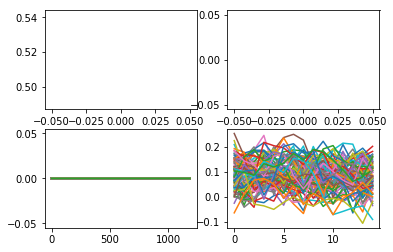

nan


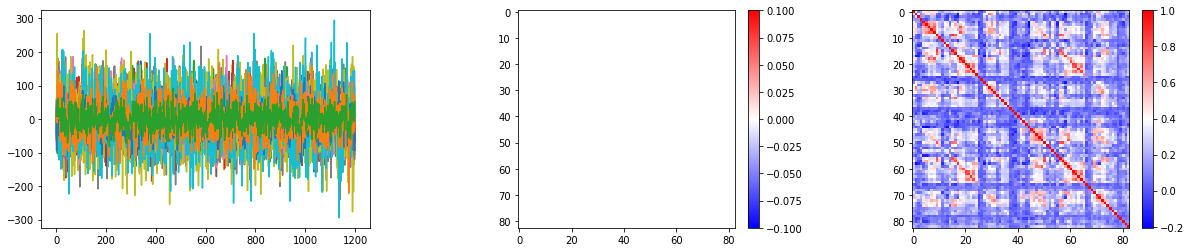

nan


/opt/Python-3.5.2/lib/python3.5/site-packages/matplotlib/image.py:405: UserWarning: Warning: converting a masked element to nan.
  dv = (np.float64(self.norm.vmax) -
/opt/Python-3.5.2/lib/python3.5/site-packages/matplotlib/image.py:406: UserWarning: Warning: converting a masked element to nan.
  np.float64(self.norm.vmin))
/opt/Python-3.5.2/lib/python3.5/site-packages/matplotlib/image.py:412: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/opt/Python-3.5.2/lib/python3.5/site-packages/matplotlib/image.py:417: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
/opt/Python-3.5.2/lib/python3.5/site-packages/matplotlib/colors.py:916: UserWarning: Warning: converting a masked element to nan.
  dtype = np.min_scalar_type(value)
/opt/Python-3.5.2/lib/python3.5/site-packages/numpy/ma/core.py:716: UserWarning: Warning: converting a masked element to nan.
  data = np.array(a, copy=False, subok=subok)


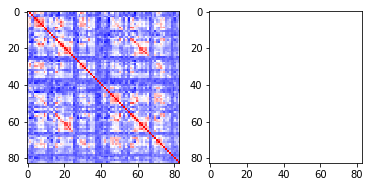

3 172332


<Figure size 432x288 with 0 Axes>

KeyboardInterrupt: 

In [15]:
batch_size = 83
HCP_par_corr= {}
ROI_size = 83
#groups= ['CON_MCI']

subs=[sub for sub in os.listdir(SC_base_dir) if os.path.isdir(SC_base_dir+sub)]
#subs = ['1']
for i in range(len(subs)):
    sub =subs[i]
    print(i, sub)
    SC_file = SC_base_dir+ sub +'/dsi_sd4/sub-' +sub +'_roisc33dwispace/weights.txt'
    TS_file = TS_base_dir+sub+ '_rfMRI_REST1_LR_hpc200_clean__l2k8_sc33_ts.pkl'
#groups= ['CON_MCI']



    
    if os.path.isfile(SC_file) and os.path.isfile(TS_file):
        HCP_par_corr[sub] = []
        SC= np.loadtxt(SC_file)
        TS_df=pd.read_pickle(TS_file)
        TS=TS_df.values
        TS_dmean =(TS.T -TS.T.mean(axis= 0)).T
        SC = (SC+SC.T)*0.5
        """SC1=SC[:48,:48].copy()
        SC2=SC[48:96,48:96].copy()
        SC3=SC[:48,48:96].copy()
        mask1 = (SC1-SC1.mean(axis=1)< 2.*SC1.std(axis=1)) 
        SC1[mask1]=0
        SC2[(SC2-SC2.mean(axis=1) <  2*SC2.std(axis=1)) ]=0
        SC3[(SC3-SC3.mean(axis=1)<  2*SC3.std(axis=1)) ]=0
        SC[:48,:48] = SC1
        SC[48:96,48:96] = SC2
        SC[:48,48:96] = 1*SC3
        SC[48:96,:48] = 1*SC3.T"""
        Wo = np.log1p(SC)/np.linalg.norm(np.log1p(SC))
        #L_s = (-np.diag(np.sum(W0, axis= 1)) + W0).astype(np.float32)
            
            
        num_data = TS.shape[0]

        total_series_length = num_data -echo_step #50000


        num_batches = total_series_length//truncated_backprop_length
            
        model_run(sub, Wo, TS)
    
        X0 = np.ones((2*batch_size,))/10.
        params = np.loadtxt(out_dir+'HCP_'+sub+'paramsList.txt')
        Theta = params[-10:,:].mean(axis = 0)

        tys=[]
        ROI_size= batch_size
        for j in range(4000):
            X = f_diffusion_tr_noise(X0,Wo, Theta)
        
            X0 = X
    
            tys.append(h_diffusion_noise(X0, Theta))
        
        tys=np.array(tys)
        #tys_dmean =(tys.T -tys.T.mean(axis= 0)).T
        FC_sim = np.corrcoef(tys[20:,:].T)
        FC=np.corrcoef(TS.T)
        np.savetxt(out_dir+'HCP_'+sub+'sim_bold.txt', np.array(tys))
        print(np.corrcoef(FC[np.tril_indices(batch_size,-1)], FC_sim[np.tril_indices(batch_size,-1)])[0,1])
        HCP_par_corr[sub].append(np.corrcoef(FC[np.tril_indices(batch_size,-1)], FC_sim[np.tril_indices(batch_size,-1)])[0,1])
            
    
        HCP_par_corr[sub].append(0.3+0.1*np.tanh(Theta[0:1])[0])
        HCP_par_corr[sub].append(40.+20.*np.tanh(Theta[1:2])[0])
        """HCP_par_corr[sub].append(.001+ smooth_normalize(Theta[2:3])[0])
        HCP_par_corr[sub].append(.1+ smooth_normalize(Theta[3:4])[0])
        HCP_par_corr[sub].append(5000./0.459/0.641+1000.*np.tanh(Theta[4:5])[0])"""
        """W_n_a = np.reshape(Theta[5:], [batch_size,batch_size])
        W_n_a = 1+ np.tanh((W_n_a+W_n_a.T)/2.0)
        W_n_a = W_n_a * Wo
    
        Ws_a = W_n_a/np.linalg.norm(W_n_a)
        HCP_par_corr[sub].extend(list(Ws_a.ravel()))"""
        
            
        fig, ax = plt.subplots(1,2)
        ax[0].imshow(FC, cmap='bwr')
        ax[1].imshow(FC_sim, cmap='bwr')
        plt.show()


 

    


In [10]:
params=np.loadtxt('/brunhild/mcintosh_lab/jwang/ModelFitting/HCP/Deco_orig/HCP_154532paramsList.txt')

In [11]:
params[0,:]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

In [ ]:
HCP_par_corr_new={}
for sub in HCP_par_corr:
    HCP_par_corr_new['sub'+sub] = HCP_par_corr[sub]

In [15]:
scipy.io.savemat(out_dir+'HCP_par_corr.mat', HCP_par_corr_new)
np.save(out_dir+'HCP_par_corr.npy', HCP_par_corr_new)

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan])

154532
0.26908398503040953


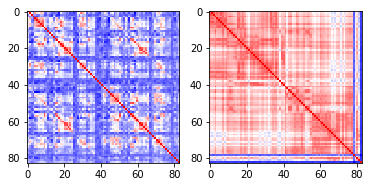

In [22]:
subs=[sub for sub in os.listdir(SC_base_dir) if os.path.isdir(SC_base_dir+sub)]
sub =subs[2]
print(sub)
SC_file = SC_base_dir+ sub +'/dsi_sd4/sub-' +sub +'_roisc33dwispace/weights.txt'
TS_file = TS_base_dir+sub+ '_rfMRI_REST1_LR_hpc200_clean__l2k8_sc33_ts.pkl'
#groups= ['CON_MCI']



    
SC= np.loadtxt(SC_file)
TS_df=pd.read_pickle(TS_file)
TS=TS_df.values
SC = (SC+SC.T)*0.5
X0 = np.ones((6*batch_size,))/10.
Wo = np.log1p(SC)/np.linalg.norm(np.log1p(SC))
params = np.loadtxt(out_dir+'HCP_'+sub+'paramsList.txt')
Theta = params[-10:,:].mean(axis = 0)

tys=[]
ROI_size= batch_size
for j in range(4000):
    X = f_diffusion_tr_noise(X0,Wo, Theta)
        
    X0 = X
    
    tys.append(h_diffusion_noise(X0, Theta))
        
tys=np.array(tys)
        #tys_dmean =(tys.T -tys.T.mean(axis= 0)).T
FC_sim = np.corrcoef(tys[50:,:].T)
FC=np.corrcoef(TS.T)
np.savetxt(out_dir+'HCP_'+sub+'sim_bold.txt', np.array(tys))
print(np.corrcoef(FC[np.tril_indices(batch_size,-1)], FC_sim[np.tril_indices(batch_size,-1)])[0,1])
        
            
fig, ax = plt.subplots(1,2)
ax[0].imshow(FC, cmap='bwr')
ax[1].imshow(FC_sim, cmap='bwr')
plt.show()

In [37]:
params[:5,:]

array([[nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan],
       [nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan]])